# Thailand Stock Price Prediction Study with Deep Learning

It is always be better to know the future especially in stock trading as we can plan well on when to buy and when to sell to make profit. 

As I search over the internet, I found some example of using deep-learning algorithms like Long Short-Term Memory (LSTM) to predict stock price. 

However, I haven't seen much example and result of tuning LSTM for different range of prediction to get the best result and also the accuracy of the model when we use it with various number of stock.

**Therefore, the objectives of the study in this notebook are:**

1. Build a stock predictor using LSTM and tune the paramters for one selected stock in predicting its Adjusted Close price in the next 1, 5 and 10 days. The way that I intend to tune the parameters are:
  - Starting by using the lowest value for all parameters and allow only one parameter to be adjusted.
  - Loop thru the cycle of build, train and validate different value of the parameters to find the best value of that parameters. 
  - Do this for all parameters to see which parameter and which value give the lowest error.
  - Update the particular parameter with value while the others is still the lowest.
  - Repeat all steps until the error doesn't get lower and that will be the set of best parameter value.

2. Build model by using the set of parameters as found from previous topics to do prediction on another set of stock and measure how many stock that the model could predict with acceptable error rate.

3. Build user-friendly script that the user is able to:
  - Provide list of stocks, date range of historical data and train the model.
  - Query the predicted price by selecting the stock and the date range of price prediction.

**Data**

As I reside in Thailand, the target list of stock for my model will be the 50 most highest value stock in Stock Exchange of Thailand (or SET50). The list is here : https://www.settrade.com/C13_MarketSummary.jsp?detail=SET50. The stock that I'll use as the sample for tuning LSTM parameters will be one of the stock from SET50.

The data that I use will be from Yahoo Finance - https://finance.yahoo.com/ which provides the historical data of Open, High, Low, Close, Adjusted Close price and trade volume.



**Metrics**

The metrics for each topics of study will be a measurement of prediction accuracy. Since, this will be measurement of how the predicted line fit the actual line. Mean Square Error would be the appropriate metrics to measure the model accuracy (the lower the better). We can even take square root to find the actual distance between the data and the predicted line.


The content from here will be a deep-drive implementation for each topic as listed above.

## 1. Build LSTM and optimize parameters for one stock in SET50 on 1,5 and 10 days prediction

***1.1 Select the workspace and install yfinance library***

First, we will need to get stock data from Yahoo Finance. **yfinance** library is the package that we need to install. It is packed with function to get the data from Yahoo Finance. The documentation can be found here - https://pypi.org/project/yfinance/.

Install yfinance using !pip install command.

In [0]:
!pip install yfinance
import yfinance as yf

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=ca57ad307e849d0b73d634259e74d4615f2796e027f79605295d8fdd4cfea639
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


As LSTM required tensorflow to build and train the model, I develop this notebook on Google's colaboratory - https://colab.research.google.com which provide free Jupyter Notebook working space with ternsorflow GPU supported installed. It is also able to read/write file to Google Drive which is quite handy for me in this situation as my personal machine doesn't has GPU.

Keras is Deep Learning library which has LSTM implemented that I'm going to use in this exploration - https://keras.io/.

To use Keras, we need to install tensorflow which is Keras's dependencies.
The code block below will import all of necessary libraries and test run to see, if the machine instance supports the library or not.



In [0]:
# Numpy and Pandas for data transformation
import numpy as np
import pandas as pd

# Datetime for handling datetime of the data
import os.path, time
import datetime

# For Plotting graph
import matplotlib.pyplot as plt

# Preprocessing for normalize data
from sklearn import preprocessing

# Keras Model and Tensorflow
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
from keras.models import Sequential
from keras.utils import plot_model

***1.2 Prepare data***

Since we will use all of SET50 data, I'll download all of them. The stock that I select to explore is INTUCH which is the one that I used to trade. 

I use colaboratory's Google Drive mounting features to store the downloaded data and also intermediate result while working on this notebook.

In [0]:
# This variable is the path to my Google Drive's folder which will use to contain the copy of SET50 historical stock data
gdrive_path = '/content/drive/My Drive/Colab Notebooks/Data/'

# List of SET50 stock list. It is from set.or.th
def get_set50_list():
  '''
    Return the array which contain list of SET50 ticker as of April 2020.
    
    Input
    - N/A

    Output
    - stock_list (Array) : Array containing list of SET50 ticker compatible with Yahoo Finance
  '''
  stock_list = [
  'ADVANC.BK','AOT.BK','AWC.BK','BANPU.BK','BBL.BK','BDMS.BK','BEM.BK','BGRIM.BK','BH.BK','BJC.BK','BTS.BK','CBG.BK','CPALL.BK','CPF.BK','CPN.BK','CRC.BK',
'DELTA.BK','DTAC.BK','EA.BK','EGCO.BK','GLOBAL.BK','GPSC.BK','GULF.BK','HMPRO.BK','INTUCH.BK','IRPC.BK','IVL.BK','KBANK.BK','KTB.BK','KTC.BK','LH.BK','MINT.BK',
'MTC.BK','OSP.BK','PTT.BK','PTTEP.BK','PTTGC.BK','RATCH.BK','SAWAD.BK','SCB.BK','SCC.BK', 'TCAP.BK','TISCO.BK','TMB.BK','TOA.BK','TOP.BK','TRUE.BK','TU.BK',
'VGI.BK','WHA.BK'
]

  return stock_list

# Define function for later use
def get_set50_data():
  '''
    This function will check the copy of historical data on my Google Drive and re-download historical file again, if it found that the last modified date is older than today.

    Input:
    - N/A

    Output:
    - No return value
    - The function will check, if the copy of historical stock data is older than today it will get the whole historical data and overwrite the same file.
  '''
  stock_list = get_set50_list()
  for stock in stock_list:
    try:
      # Define the file path
      file = gdrive_path+stock+'.csv'

      # Get the last modified date, if it is today we will skip this file otherwise download all historical data and save to file
      modified_date = datetime.datetime.strptime(time.ctime(os.path.getmtime(file)),'%a %b %d %H:%M:%S %Y')
      if datetime.datetime.now().date() != modified_date.date():
        stock_data = yf.Ticker(stock)
        pd.DataFrame(stock_data.history(period='max',auto_adjust=False,actions=False)).to_csv(file)
    except:
      # Write any exception to file to figure it out later
      stock_data = yf.Ticker(stock)
      pd.DataFrame(stock_data.history(period='max',auto_adjust=False,actions=False)).to_csv(file)

In [0]:
# Call the function
get_set50_data()

# Explore our data
stock = 'INTUCH.BK'
filename = gdrive_path+stock+'.csv'

df = pd.read_csv(filename)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1995-01-03,30.36,30.36,30.14,30.36,2.46,68960
1,1995-01-04,30.25,30.47,30.14,30.36,2.46,78350
2,1995-01-05,30.47,30.91,30.36,30.47,2.47,123290
3,1995-01-06,30.47,30.58,30.14,30.14,2.44,52350
4,1995-01-09,30.14,30.14,29.14,29.69,2.41,141170


In [0]:
# Check null data
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [0]:
# Check data type of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6240 entries, 0 to 6239
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6240 non-null   object 
 1   Open       6240 non-null   float64
 2   High       6240 non-null   float64
 3   Low        6240 non-null   float64
 4   Close      6240 non-null   float64
 5   Adj Close  6240 non-null   float64
 6   Volume     6240 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 341.4+ KB


Base on quick check, the data is quite ready to use.

After we have got all of the data, we have to make it ready to train the model.
Here is the list of things to do:
 1. Drop null rows (if any) as we can't use it anyway.
 2. Drop ate as we can't use it as features in model training.
 3. Normalize the data to have the value between 0-1 as it will help neural network has better performance. This is per this post : https://towardsdatascience.com/why-data-should-be-normalized-before-training-a-neural-network-c626b7f66c7d
 4. Transform the data format. We will predict the Adj. Close for the period of prediction day range (1,5 and 10). So, the dataset will consist of the set of Open, High, Low, Volume of each day for the number of history points day that we will use to do prediction.
 
 For example, if we say we want to use 30 history points. One row of our dataset will consists of the following features:
 
 `[dayAopen, dayAclose, dayAvolume, dayAhigh, dayAlow,dayA-1open, dayA-1close, dayA-1volume, dayA-1high, dayA-1low....dayA-29low]`

In [0]:
# Construct the CSV filepath for INTUCH.BK
stock = 'INTUCH.BK'
filename = gdrive_path+stock+'.csv'

# Read the file and drop null row
df = pd.read_csv(filename)
df_na = df.dropna(axis=0)
# Drop Date as this is time series data, Date isn't used. Also drop Close as we will predict Adj Close.
df_na = df_na.drop(['Date','Close'],axis=1)

# As neural network has better performance with normalize data, we will normalize the data before train and predict
# After we got the predict result, we will scale them back to normal value to measure error rate.
# Normalise all data to the value range of 0-1 as neural network algorithm has better performance with this data range
data_normaliser = preprocessing.MinMaxScaler()
y_normaliser = preprocessing.MinMaxScaler()
data_normalised = data_normaliser.fit_transform(df_na)    

# The length of dataset, number of day to predict and number of features
history_points = 30
predict_range = 1

# Prepare the data in the format of [day-1-open,day-1-max,day-1-min,...day-history_point ] as 1 row input for predict the 'predict_range' price for train and test
ohlcv_histories_normalised = np.array([data_normalised[i  : i + history_points].copy() for i in range(len(data_normalised) - history_points - predict_range +1)])

# Get the actual price [day1-adj close,day2-adj close....day-predict_range adj close] for train and test
next_day_adjclose_values_normalised = np.array([data_normalised[i + history_points:i + history_points + predict_range,3].copy() for i in range(len(data_normalised) - history_points - predict_range+1)])

# Create the same array as the normalised adj close but with the actual value not the scaled down value. This is used to calculate the prediction accuracy
next_day_adjclose_values = np.array([df_na.iloc[i + history_points:i + history_points+predict_range]['Adj Close'].values.copy() for i in range(len(df_na) - history_points - predict_range+1)])    

# Use the passed normaliser to fit the actual value so that we can scale the predicted result back to actual value
y_normaliser.fit(next_day_adjclose_values)

MinMaxScaler(copy=True, feature_range=(0, 1))

Now, the data is ready. As we are going to train the model, we will have to split the data to train and test.

In [0]:
def train_test_split(ohlcv_histories, next_day_adj_close, unscaled_y,test_split = 0.9):
    '''
        Split the dataset to train and test dataset per provideed ratio.

        Input
        - ohlcv_histories (Array) : The dataset in array.
        - next_day_adj_close (Array) : The result of prediction using the dataset in array.
        - unscaled_y (Array) : The same data as next_day_adj_close but not normalize to 0-1.
        - test_split (Float) : The ratio of train per test.

        Output
        - ohlcv_train (Array) : The train dataset splitted per test_split ratio.
        - ohlcv_test (Array) : The test dataset splitted per test_split ratio.
        - y_test (Array) : The result of test dataset splitted per test_split ratio.
        - y_train (Array) : The result of train dataset splitted per test_split ratio.
        - unscaled_y_test (Array) : The unscaled y_test per test_split ratio.
    '''
    n = int(ohlcv_histories.shape[0] * test_split)

    ohlcv_train = ohlcv_histories[:n]
    y_train = next_day_adj_close[:n]

    ohlcv_test = ohlcv_histories[n:]
    y_test = next_day_adj_close[n:]

    unscaled_y_test = unscaled_y[n:]

    return ohlcv_train, ohlcv_test, y_test, y_train, unscaled_y_test

In [0]:
ohlcv_train, ohlcv_test, y_test, y_train, unscaled_y_test = train_test_split(ohlcv_histories_normalised, next_day_adjclose_values_normalised, next_day_adjclose_values)

***1.3 Build, Train and Validate the model***

Then, it is ready to create LSTM model, train and validate the model by using mean squared error. LSTM that I will use is a simple one consist of hidden layer, dropout layer, and forecast layer.

I create as function so that I can change the parameters of the model.

In [0]:
def get_LSTM_Model(layer_num, history_points, features_num,predict_range,optimizer,dropout_prob):

    '''
      This function will build LSTM model per provided parameters.
      The model will be a simple one consist of one forget layer with configurable forget probability and configurable number of hidden layers.

      Input:
      - layer_num (Number) : The number of hidden layer.
      - history_points (Number) : The number of data in the dataset.
      - features_num (Number) : The number of features in the dataset.
      - predict_range (Number) : The number of day to predict the stock price.
      - optimizer (Number) : The optimizer's name e.g. adam.
      - dropout_prob (Float) : Probability to forget the date on dropout layer.

      Output:
      - model (Object) : The compiled LSTM model per the provided parameters.

    '''

    # Initialize LSTM using Keras library
    model = Sequential()
    # Defining hidden layer number and the shape of the input (number of data in the dataset and the number of feature)
    model.add(LSTM(layer_num, input_shape=(history_points, features_num)))

    # Add forget (dropout) layer with probability per argument
    model.add(Dropout(dropout_prob))

    # End the network with hiddenlayer per the size of forecast day e.g. 1,5,10
    model.add(Dense(predict_range))

    # Build and return the model per the selected optimizer
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [0]:
# Must be the same as history point that we use to prepare data
history_points = 30
# Must be the same number of features when we prepare data
features_num = 5

# LSTM parameters
layer_num = 30
predict_range = 1
optimizer = 'adam'
dropout_prob = 1.0

# Create LSTM model object
model = get_LSTM_Model(layer_num, history_points, features_num,predict_range,optimizer,dropout_prob)

# Parameter for model training
batch_size = 10
epoch = 10
# Train model with our train data
model.fit(x=ohlcv_train, y=y_train, batch_size=batch_size, epochs=epoch, shuffle=True, validation_split=0.1)

# The model is train. Test with the test dataset
y_test_predicted = model.predict(ohlcv_test)
# Scale up the result to actual value with y_normaliser that we use earlier
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)

# Calculate the error with MSE
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100

print('scaled_mse = ' + str(scaled_mse))

Train on 5030 samples, validate on 559 samples
Epoch 1/10
5030/5030 [==============================] - 7s 1ms/step - loss: 0.0039 - val_loss: 9.9107e-04
Epoch 2/10
5030/5030 [==============================] - 6s 1ms/step - loss: 1.9327e-04 - val_loss: 0.0011
Epoch 3/10
5030/5030 [==============================] - 6s 1ms/step - loss: 1.6206e-04 - val_loss: 5.4024e-04
Epoch 4/10
5030/5030 [==============================] - 6s 1ms/step - loss: 1.4546e-04 - val_loss: 4.7951e-04
Epoch 5/10
5030/5030 [==============================] - 6s 1ms/step - loss: 1.5607e-04 - val_loss: 4.6622e-04
Epoch 6/10
5030/5030 [==============================] - 6s 1ms/step - loss: 1.2930e-04 - val_loss: 3.8459e-04
Epoch 7/10
5030/5030 [==============================] - 6s 1ms/step - loss: 1.3574e-04 - val_loss: 6.1380e-04
Epoch 8/10
5030/5030 [==============================] - 6s 1ms/step - loss: 1.1526e-04 - val_loss: 4.1307e-04
Epoch 9/10
5030/5030 [==============================] - 6s 1ms/step - loss: 9.064

In [0]:
# Visualize the predicted price and the actual price
def display_test_validation_graph(unscaled_y_test, y_test_predicted):
    '''
        Display the plot of the stock price in test dataset and the predicted data.

        Input
        - unscaled_y_test (Array) : The array of stock price in test dataset.
        - y_test_predicted (Array) : The array of stock price as predicted.

        Output
        - No return value.
        - The plot will be displayed on the screen.
    '''
    plt.gcf().set_size_inches(22, 15, forward=True)

    start = 0
    end = -1

    real = plt.plot(unscaled_y_test[start:end], label='real')
    pred = plt.plot(y_test_predicted[start:end], label='predicted')

    plt.legend(['Real', 'Predicted'])

    plt.show()



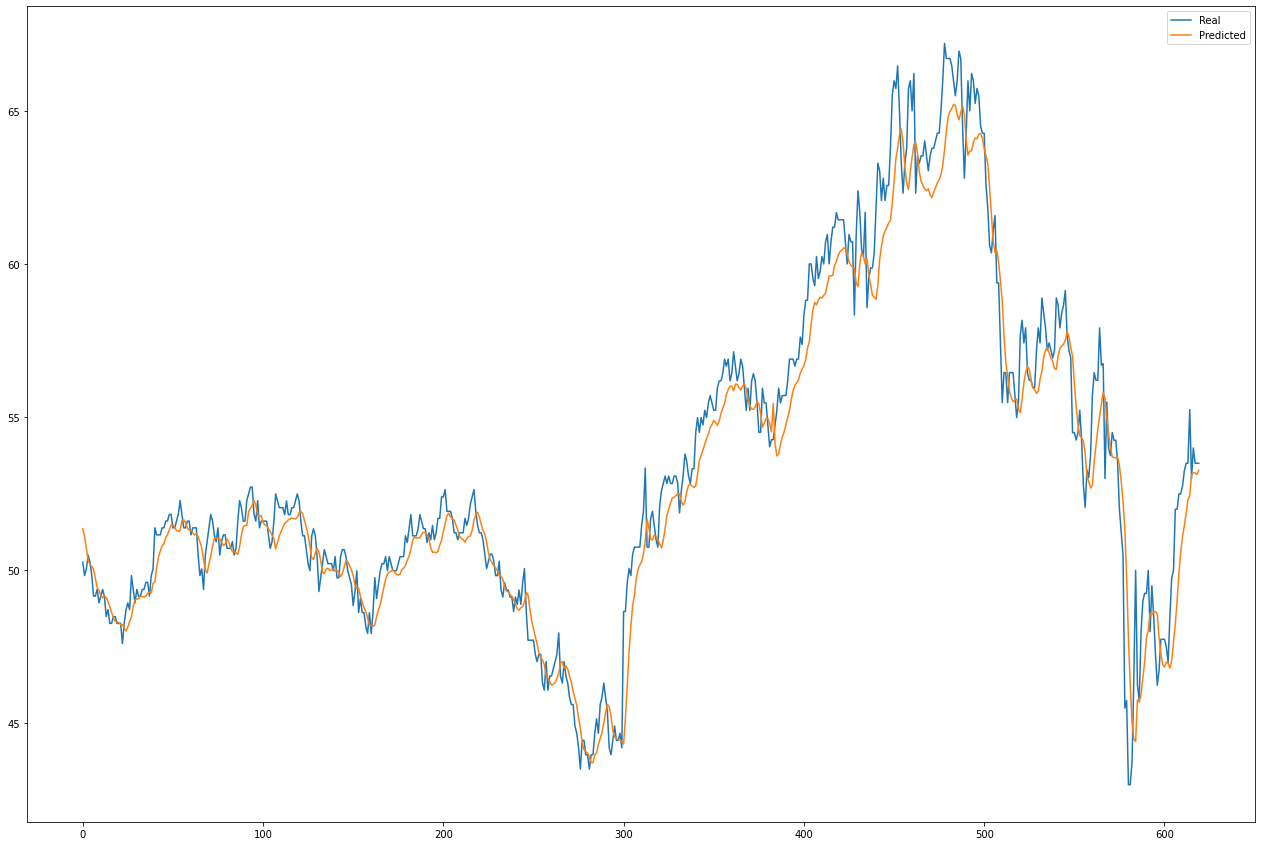

In [0]:
display_test_validation_graph(unscaled_y_test,y_test_predicted)

***1.4 Optimize parameters for 1 day prediction***

Next steps, I will try to optimize the model for 1 day prediction by looping thru the range of value for each parameter, use the value of each iteration to train the model and record the accuracy. So, I'll encapsulate the sequences of function call to be one function for better read ability and also create function for tuning each parameter.

1. **dataset_preparation** : This function uses to prepare data per given file path or given dataframe.

2. **train_predictor** : This function uses to train the model by being able to define the parameters for building the model and train the model. The function will also build LSTM model by using get_LSTM_Model function as defined earlier. 

3. **train_and_validate_stock_predictor** : This function will encapsulate all of the steps from data preparation, build model, train and calcurate accuracy. The function will return the trained model and the scaled mse of the model.

4. **add_macd_ema** : This function will calculate some of technical analysis indicators and add to the input stock dataframe. In this case, I use MACD and EMA.

In [0]:
def dataset_preparation(filename, history_points, predict_range, y_normaliser, mode='file', df=None):
    '''
      This function will prepare data and make it ready for training and testing the model by receiving the CSV file path or dataframe 
      equivalent to Yahoo Finance's historical data with other parameters, normalize to 0-1 range value, separate into train and test and return the result.

      Input:
      - filename (String) : The file path for csv file containing historical stock data downloaded from Yahoo Finance. 
      - history_points (Number) : The number of day range for historical data to be used for training the model.
      - predict_range (Number) : The range of day to forecast the price.
      - y_normmalizer (preprocessing.MinMaxScaler Object) :  Preprocessor for normalize the price for forecast data to be 0-1. We need this so that we could use it again for scaling up the data back to normal value.
      - df (DataFrame) : The dataframe input of the dataset. If the filename is passed and the mode is set to'file' it will be ignored.
      - mode : If it is 'file' the function will ignore df otherwise it will assume that df will be provided for preparation. This is used in the case that the data is read from CSV and append with other data features.

      Output:
      - ohlcv_histories_normalised (Array) : Array of the data features. One row consist of [day-1-open,day-1-max,day-1-min,...day-history_point ].
      - next_day_adjclose_values_normalised (Array) : Array of normalised Adj Close values transformed in the format of [day1-adj close,day2-adj close....day-predict_range adj close].
      - next_day_adjclose_values (Array) : Array of actual Adj Close values transformed in the format of [day1-adj close,day2-adj close....day-predict_range adj close].
      - y_normaliser (preprocessing.MinMaxScaler Object) : After we fit the actual value, we return it back so that it can be used again to scale the normalized result.
    '''

    # Prepare data per mode - file or dataframe input
    if mode=='file':
      # If it is file mode the function expect CSV file path to read the data
      df = pd.read_csv(filename)

    # For both mode, we will drop row with null value as we can't use it anyway
    df_na = df.dropna(axis=0)
    # Drop Date as this is time series data, Date isn't used. Also drop Close as we will predict Adj Close.
    df_na = df_na.drop(['Date','Close'],axis=1)

    # Normalise all data to the value range of 0-1 as neural network algorithm has better performance with this data range
    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(df_na)

    # Prepare the data in the format of [day-1-open,day-1-max,day-1-min,...day-history_point ] as 1 row input for predict the 'predict_range' price for train and test
    ohlcv_histories_normalised = np.array([data_normalised[i  : i + history_points].copy() for i in range(len(data_normalised) - history_points - predict_range +1)])

    # Get the actual price [day1-adj close,day2-adj close....day-predict_range adj close] for train and test
    next_day_adjclose_values_normalised = np.array([data_normalised[i + history_points:i + history_points + predict_range,3].copy() for i in range(len(data_normalised) - history_points - predict_range+1)])

    # Create the same array as the normalised adj close but with the actual value not the scaled down value. This is used to calculate the prediction accuracy
    next_day_adjclose_values = np.array([df_na.iloc[i + history_points:i + history_points+predict_range]['Adj Close'].values.copy() for i in range(len(df_na) - history_points - predict_range+1)])    

    # Use the passed normaliser to fit the actual value so that we can scale the predicted result back to actual value
    y_normaliser.fit(next_day_adjclose_values)

    return ohlcv_histories_normalised, next_day_adjclose_values_normalised, next_day_adjclose_values, y_normaliser

def train_predictor(ohlcv_train,y_train,ohlcv_test,y_normaliser,unscaled_y_test,hidden_layer,batch_size,epoch,dropout_probability,history_points,features_num,predict_range):
    '''
        Create LSTM model per provideded parameter, fit the train data and validate its accuracy using MSE.
        Finally, retrun the result of MSE and the model object.

        Input
        - ohlcv_train (Array) : Train dataset in array.
        - y_train (Array) : Train dataset result in array.
        - ohlcv_test (Array) : Test dataset in array.
        - y_normaliser (preprocessing.MinMaxScaler Object) : The normaliser instance that is used to scale down y_test. We will use it to scale up the result from test dataset.
        - unscaled_y_test (Array) : The unscaled y_test using for validate the result.
        - hidden_layer (Number) : LSTM parameter's number of hidden layer.
        - batch_size (Number) : LSTM parameter's number of batch size.
        - epoch (Number) : LSTM parameter's number of epoch.
        - dropout_probability (Float) : LSTM parameter's dropout probability.
        - history_points (Number) : LSTM parameter's the number of history data to train the model in each iteration.
        - features_num (Number) : LSTM parameter's the number of features in the dataset.
        - predict_range : LSTM parameter's the number of predict data to be predicted.

        Output
        - model (Object) : LSTM model which can be saved to h5 or use to predict the result with the new dataset.
        - scaled_mse (Float) : Mean Squared Error of the model measured by using the unscaled result from test dataset minus the unscaled_y_test

    '''
    # Build model 
    model = get_LSTM_Model(hidden_layer,history_points,features_num,predict_range,'adam',dropout_probability)
    # Train model with the train data set
    model.fit(x=ohlcv_train, y=y_train, batch_size=batch_size, epochs=epoch, shuffle=True, validation_split=0.1,verbose=0)

    # Get the predict result by using test dataset
    y_test_predicted = model.predict(ohlcv_test)
    # Scale up the test result
    y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)

    # Calculate the mse
    real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
    scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100

    return model, scaled_mse

def train_and_validate_stock_predictor(stock,history_points,predict_range,hidden_layer,batch_size,epoch,dropout_probability, mode='file'):
    '''
        Encapsulate all activities to create LSTM model to predict the stock with parameters as provided.
        There are 2 mode for this function. mode='file' will read data from csv file and not add additional features like macd and EMA
        while other mode will read data from csv but also add macd and EMA as additional features.
        Starting from transforming data, splitting to train/test, build and fit model, evaluate the model accuracy and return result.

        Input
        - stock (String) : Ticker per Yahoo Finance.
        - history_points (Number) : LSTM parameter's the number of history data to train the model in each iteration.
        - predict_range : LSTM parameter's the number of predict data to be predicted.
        - hidden_layer (Number) : LSTM parameter's number of hidden layer.
        - batch_size (Number) : LSTM parameter's number of batch size.
        - epoch (Number) : LSTM parameter's number of epoch.
        - dropout_probability (Float) : LSTM parameter's dropout probability.

        Output
        - model (Object) : LSTM model which can be saved to h5 or use to predict the result with the new dataset.
        - scaled_mse (Float) : Mean Squared Error of the model measured by using the unscaled result from test dataset minus the unscaled_y_test
    '''
    # If mode is file the data will be read from file which is expected to be at the path per gdrive_path definition
    if mode=='file':
        # In this case features number will be 5 
        features_num = 5
        # Prepare data
        ohlcv_histories, next_day_adj_close, unscaled_y, y_normaliser = dataset_preparation(gdrive_path+stock+'.csv',history_points,predict_range,preprocessing.MinMaxScaler())
    else:
    # Dataframe mode, in this mode MACD and EMA will be add to the input DataFrame as additional features
        df = add_macd_ema(pd.read_csv(gdrive_path+stock+'.csv'))
        # Prepare data
        ohlcv_histories, next_day_adj_close, unscaled_y, y_normaliser = dataset_preparation('',history_points,predict_range,preprocessing.MinMaxScaler(),mode='df',df=df)
        # In this case features number will equall to DataFrame's columns minus 2 (we drop in dataset_preparation Date and Close)
        features_num = len(df.columns)-2

    # Split train and test data
    ohlcv_train, ohlcv_test, y_test, y_train, unscaled_y_test = train_test_split(ohlcv_histories,next_day_adj_close,unscaled_y)

    # Build, train, test and return mode and MSE
    model, scaled_mse = train_predictor(ohlcv_train,y_train,ohlcv_test,y_normaliser,unscaled_y_test,hidden_layer,batch_size,epoch,dropout_probability,history_points,features_num,predict_range)
    return model, scaled_mse

def add_macd_ema(df,ema1=20,ema2=50):
    '''
        Compute stock technical analysis indicator - MACD and EMA and add back to the dataset

        Input
        - df (DataFrame) : The DataFrame of stock data as downloaded from Yahoo Finance
        - ema1 (Number) : The first EMA period to add to the dataset
        - ema2 (Number) : The second EMA period to add to the dataset

        Output
        - df (DataFrame) : The DataFrame with new columns added - MACD, ema1 and ema2 e.g. MACD, 20, 50 are the default column name that will be added
    '''
    # Extract Close data to calculate MACD
    df_close = df[['Close']]
    df_close.reset_index(level=0, inplace=True)
    df_close.columns=['ds','y']

    # Calculate MACD by using DataFrame's EWM https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    exp1 = df_close.y.ewm(span=12, adjust=False).mean()
    exp2 = df_close.y.ewm(span=26, adjust=False).mean()
    macd = exp1-exp2

    # Merge MACD back as new column to the input df
    df = pd.merge(df,macd,how='left',left_on=None, right_on=None, left_index=True, right_index=True)

    # Rename DataFrame columns
    df.columns = ['Date','Open','High','Low','Close','Adj Close','Volume','MACD']

    # Add new columns using EMA windwos size. EWM can use directly.
    df[ema1] = df['Close'].ewm(span=ema1, adjust=False).mean()
    df[ema2] = df['Close'].ewm(span=ema2, adjust=False).mean()

    return df

With these functions as foundation, I create another functions to find the best parameter value for build and train the model. The following functions will write the scaled MSE of each parameter value.

Recommend to mount Google Drive to write the result and mot losing it due to the notebook instance getting expired.

Next, we will iterate each parameter value range while keep other parameters at lowest to find the best value of the particular parameter. 

As we will have run thru these steps many times, I encapsulate each step to find the best value for each parameters into functions.

In [0]:
def get_best_hidden_layer(predict_range, max_hidden_layer, stock_list, history_points=30, batch_size=10,epoch=10,dropout_probability=1.0,mode='file'):
  '''
    This function loop thru the range of hidden_layer from 10 to MAX_HIDDEN_LAYER for 10 iterations 
    to calculate MSE for each hidden_layer.

    Input:
    - predict_range (Number) : Range of day to do prediction.
    - max_hidden_layer (Number) : The max number of hidden layer.
    - stock_list (Array) : List of stock to loop thru and calculaute MSE.
    - history_points (Number) : History points for preparing the data, training and validating the model. Default is 30.
    - batch_size (Number) : Size of batch for training the model. The default is 10.
    - epoch (Number) : Number of epoch for training the model. The default is 10.
    - dropout_probability (Float) : The propability of the dropout layer of the LSTM. The default is 1.0.
    - mode (String) : The mode for adding MACD and EMA or not. Defult if 'file' meaning not add these features.

    Output:
    - No return value
    - The MSE of each hidden_layer value will be written to CSV output file on Google Drive.
    
  '''
  mse_list = []
  exception_list = []

  for hidden_layer in range(10,max_hidden_layer+1,round(max_hidden_layer/10)):
    for stock in stock_list:
      try:  
        model, scaled_mse = train_and_validate_stock_predictor(stock,history_points,predict_range,hidden_layer,batch_size,epoch,dropout_probability,mode)
        print("Predict {} days for {} with MSE = {}".format(str(predict_range),str(stock),str(scaled_mse)))
        mse_list.append([hidden_layer,stock,scaled_mse])
        pd.DataFrame(mse_list).to_csv('/content/drive/My Drive/Colab Notebooks/stocklist_'+str(predict_range)+'_mse_layer_'+mode+'.csv')
      except Exception as e:
        print("exception "+str(e)+"on "+stock)
        exception_list.append([predict_range,stock,str(e)])
        pd.DataFrame(exception_list).to_csv('/content/drive/My Drive/Colab Notebooks/exception_list.csv')
        continue

def get_best_history_points(predict_range, max_history_points, stock_list, hidden_layer=10, batch_size=10,epoch=10,dropout_probability=1.0,mode='file'):
  '''
    This function loop thru the range of history_points from 10 to max_history_points for 10 iterations 
    to calculate MSE for each history_points.

    Input:
    - predict_range (Number) : Range of day to do prediction.
    - max_history_points (Number) : The max number of hidden points for preparing the data, train and test the model.
    - stock_list (Array) : List of stock to loop thru and calculaute MSE.
    - hidden_layer (Number) : Number of layer for building the model.
    - batch_size (Number) : Size of batch for training the model. The default is 10.
    - epoch (Number) : Number of epoch for training the model. The default is 10.
    - dropout_probability (Float) : The propability of the dropout layer of the LSTM. The default is 1.0.
    - mode (String) : The mode for adding MACD and EMA or not. Defult if 'file' meaning not add these features.

    Output:
    - No return value
    - The MSE of each hidden_layer value will be written to CSV output file on Google Drive.
    
  '''
  mse_list = []
  exception_list = [] 

  for history_points in range(30,max_history_points+1,round(max_history_points/10)):
    for stock in stock_list:
      try:  
        model, scaled_mse = train_and_validate_stock_predictor(stock,history_points,predict_range,hidden_layer,batch_size,epoch,dropout_probability,mode)
        print("Predict {} days for {} with MSE = {}".format(str(predict_range),str(stock),str(scaled_mse)))
        mse_list.append([history_points,stock,scaled_mse])
        pd.DataFrame(mse_list).to_csv('/content/drive/My Drive/Colab Notebooks/stocklist_'+str(predict_range)+'_mse_history_'+mode+'.csv')
      except Exception as e:
        print("exception "+str(e)+"on "+stock)
        exception_list.append([predict_range,stock,str(e)])
        pd.DataFrame(exception_list).to_csv('/content/drive/My Drive/Colab Notebooks/exception_list.csv')
        continue

def get_best_batch_size(predict_range, max_batch_size, stock_list, hidden_layer=10, history_points=30, batch_size=10,epoch=10,dropout_probability=1.0,mode='file'):
  '''
    This function loop thru the range of batch_size from 10 to max_batch_size for 10 iterations 
    to calculate MSE for each batch_size.

    Input:
    - predict_range (Number) : Range of day to do prediction.
    - max_batch_size (Number) : The max size of batch for training the model.
    - stock_list (Array) : List of stock to loop thru and calculaute MSE.
    - hidden_layer (Number) : Number of layer for building the model.
    - history_points (Number) : History points for preparing the data, training and validating the model. Default is 30.
    - batch_size (Number) : Size of batch for training the model. The default is 10.
    - epoch (Number) : Number of epoch for training the model. The default is 10.
    - dropout_probability (Float) : The propability of the dropout layer of the LSTM. The default is 1.0.
    - mode (String) : The mode for adding MACD and EMA or not. Defult if 'file' meaning not add these features.

    Output:
    - No return value
    - The MSE of each hidden_layer value will be written to CSV output file on Google Drive.
    
  '''
  mse_list = []
  exception_list = [] 

  for batch_size in range(10,max_batch_size+1,round(max_batch_size/10)):
    for stock in stock_list:
      try:  
        model, scaled_mse = train_and_validate_stock_predictor(stock,history_points,predict_range,hidden_layer,batch_size,epoch,dropout_probability,mode)
        print("Predict {} days for {} with MSE = {}".format(str(predict_range),str(stock),str(scaled_mse)))
        mse_list.append([batch_size,stock,scaled_mse])
        pd.DataFrame(mse_list).to_csv('/content/drive/My Drive/Colab Notebooks/stocklist_'+str(predict_range)+'_mse_batch_'+mode+'.csv')
      except Exception as e:
        print("exception "+str(e)+"on "+stock)
        exception_list.append([predict_range,stock,str(e)])
        pd.DataFrame(exception_list).to_csv('/content/drive/My Drive/Colab Notebooks/exception_list.csv')
        continue
  
def get_best_dropout_prob(predict_range, stock_list, hidden_layer=10, history_points=30, batch_size=10,epoch=10,dropout_probability=1.0,mode='file'):
  '''
    This function loop thru the range of dropout_probability to calculate MSE for each dropout_probability.

    Input:
    - predict_range (Number) : Range of day to do prediction.
    - stock_list (Array) : List of stock to loop thru and calculaute MSE.
    - hidden_layer (Number) : Number of layer for building the model.
    - history_points (Number) : History points for preparing the data, training and validating the model. Default is 30.
    - batch_size (Number) : Size of batch for training the model. The default is 10.
    - epoch (Number) : Number of epoch for training the model. The default is 10.
    - dropout_probability (Float) : The propability of the dropout layer of the LSTM. The default is 1.0.
    - mode (String) : The mode for adding MACD and EMA or not. Defult if 'file' meaning not add these features.

    Output:
    - No return value
    - The MSE of each hidden_layer value will be written to CSV output file on Google Drive.
    
  '''
  mse_list = []
  exception_list = [] 

  for dropout_probability in [0.1,0.3,0.5,0.8,1.0]:
    for stock in stock_list:
      try:  
        model, scaled_mse = train_and_validate_stock_predictor(stock,history_points,predict_range,hidden_layer,batch_size,epoch,dropout_probability,mode)
        print("Predict {} days for {} with MSE = {}".format(str(predict_range),str(stock),str(scaled_mse)))
        mse_list.append([dropout_probability,stock,scaled_mse])
        pd.DataFrame(mse_list).to_csv('/content/drive/My Drive/Colab Notebooks/stocklist_'+str(predict_range)+'_mse_dropprob_'+mode+'.csv')
      except Exception as e:
        print("exception "+str(e)+"on "+stock)
        exception_list.append([predict_range,stock,str(e)])
        pd.DataFrame(exception_list).to_csv('/content/drive/My Drive/Colab Notebooks/exception_list.csv')
        continue

def get_best_epoch(predict_range, max_epoch, hidden_layer=10, history_points=30, batch_size=10,dropout_probability=1.0,mode='file'):
  '''
    This function loop thru the range of epoch from 10 to max_epoch for 10 iterations 
    to calculate MSE for each max_epoch.

    Input:
    - predict_range (Number) : Range of day to do prediction.
    - max_epoch (Number) : The max size of epoch for training the model.
    - stock_list (Array) : List of stock to loop thru and calculaute MSE.
    - hidden_layer (Number) : Number of layer for building the model.
    - history_points (Number) : History points for preparing the data, training and validating the model. Default is 30.
    - batch_size (Number) : Size of batch for training the model. The default is 10.
    - dropout_probability (Float) : The propability of the dropout layer of the LSTM. The default is 1.0.
    - mode (String) : The mode for adding MACD and EMA or not. Defult if 'file' meaning not add these features.

    Output:
    - No return value
    - The MSE of each hidden_layer value will be written to CSV output file on Google Drive.
    
  '''
  mse_list = []
  exception_list = [] 

  for epoch in range(10,max_epoch+1,round(max_epoch/10)):
    for stock in stock_list:
      try:  
        model, scaled_mse = train_and_validate_stock_predictor(stock,history_points,predict_range,hidden_layer,batch_size,epoch,dropout_probability,mode)
        print("Predict {} days for {} with MSE = {}".format(str(predict_range),str(stock),str(scaled_mse)))
        mse_list.append([epoch,stock,scaled_mse])
        pd.DataFrame(mse_list).to_csv('/content/drive/My Drive/Colab Notebooks/stocklist_'+str(predict_range)+'_mse_epoch_'+mode+'.csv')
      except Exception as e:
        print("exception "+str(e)+"on "+stock)
        exception_list.append([predict_range,stock,str(e)])
        pd.DataFrame(exception_list).to_csv('/content/drive/My Drive/Colab Notebooks/exception_list.csv')
        continue

Starting with running all these functions to see which parameter and which of its value give the lowest MSE.

In [0]:
# 1st Round run all get best parameter function to find the best performer
predict_range = 1
max_hidden_layer = 100
max_history_points = 100
max_batch_size = 100
max_epoch = 100

stock_list = ['INTUCH.BK']

get_best_hidden_layer(predict_range, max_hidden_layer, stock_list)
get_best_history_points(predict_range, max_history_points, stock_list)
get_best_batch_size(predict_range, max_batch_size, stock_list)
get_best_dropout_prob(predict_range, stock_list)
get_best_epoch(predict_range, max_epoch)

Predict 1 days for INTUCH.BK with MSE = 5.437020560606206
Predict 1 days for INTUCH.BK with MSE = 4.789881003383009
Predict 1 days for INTUCH.BK with MSE = 6.419029833424765
Predict 1 days for INTUCH.BK with MSE = 11.030013748353054
Predict 1 days for INTUCH.BK with MSE = 15.586890158371489
Predict 1 days for INTUCH.BK with MSE = 5.126618152750369
Predict 1 days for INTUCH.BK with MSE = 4.244161823471961
Predict 1 days for INTUCH.BK with MSE = 3.804861242754052
Predict 1 days for INTUCH.BK with MSE = 3.8394154365567417
Predict 1 days for INTUCH.BK with MSE = 3.7218740547398146
Predict 1 days for INTUCH.BK with MSE = 8.530680191531463
Predict 1 days for INTUCH.BK with MSE = 5.343105265934106
Predict 1 days for INTUCH.BK with MSE = 5.6027384517625975
Predict 1 days for INTUCH.BK with MSE = 5.09464684124055
Predict 1 days for INTUCH.BK with MSE = 6.221215812694935
Predict 1 days for INTUCH.BK with MSE = 6.493592533132878
Predict 1 days for INTUCH.BK with MSE = 9.613755600348895
Predict 1 

From first round of tune we found that epoch = 90 has the lowest MSE at ~2.85%

We will run all functions except epoch again and also fix epoch value at 60 as input to all functions. This is to find other parameters that could decrease MSE further.

In [0]:
# 2nd round. Fix epoch at 90 and run other get best parameters function to improve further.
# Target is to lower MSE than 2.85%

predict_range = 1
max_hidden_layer = 100
max_history_points = 100
max_batch_size = 100
epoch = 90

stock_list = ['INTUCH.BK']

get_best_hidden_layer(predict_range, max_hidden_layer, stock_list , epoch = epoch)
get_best_history_points(predict_range, max_history_points, stock_list, epoch = epoch)
get_best_batch_size(predict_range, max_batch_size, stock_list, epoch = epoch)
get_best_dropout_prob(predict_range, stock_list, epoch = epoch)

Predict 1 days for INTUCH.BK with MSE = 4.19634685815648
Predict 1 days for INTUCH.BK with MSE = 4.8248578781579194
Predict 1 days for INTUCH.BK with MSE = 2.8311195256984294
Predict 1 days for INTUCH.BK with MSE = 4.1369247583570505
Predict 1 days for INTUCH.BK with MSE = 2.8889748118049803
Predict 1 days for INTUCH.BK with MSE = 3.730403027303463
Predict 1 days for INTUCH.BK with MSE = 3.7048148909005216
Predict 1 days for INTUCH.BK with MSE = 3.2436087922250905
Predict 1 days for INTUCH.BK with MSE = 3.07670312217347
Predict 1 days for INTUCH.BK with MSE = 5.036327039412631
Predict 1 days for INTUCH.BK with MSE = 3.0923898371062646
Predict 1 days for INTUCH.BK with MSE = 2.921250823757324
Predict 1 days for INTUCH.BK with MSE = 3.2924466655881104
Predict 1 days for INTUCH.BK with MSE = 3.67041754160447
Predict 1 days for INTUCH.BK with MSE = 2.799535718501062
Predict 1 days for INTUCH.BK with MSE = 2.9393532321948452
Predict 1 days for INTUCH.BK with MSE = 2.899471429293753
Predict 

Foud that if history points = 90 and epoch = 90, it can reduce about MSE to ~2.79%

Then, I'll fix epoch = 90 and history points = 90 and repeat the same step again.



In [0]:
# 3rd round. Fix epoch at 90 and fix history_points at 90.
# Run other get best parameters function to improve MSE lower than 2.79%.
predict_range = 1
max_hidden_layer = 100
max_batch_size = 100
epoch = 90
history_points = 90

stock_list = ['INTUCH.BK']

get_best_hidden_layer(predict_range, max_hidden_layer, stock_list , epoch = 60,history_points=70)
get_best_batch_size(predict_range, max_batch_size, stock_list, epoch = 60,history_points=70)
get_best_dropout_prob(predict_range, stock_list, epoch = 60,history_points=70)

Predict 1 days for INTUCH.BK with MSE = 4.201759599415332
Predict 1 days for INTUCH.BK with MSE = 2.8779869710491135
Predict 1 days for INTUCH.BK with MSE = 3.1484410202691464
Predict 1 days for INTUCH.BK with MSE = 2.8964917973600164
Predict 1 days for INTUCH.BK with MSE = 3.3884709927712025
Predict 1 days for INTUCH.BK with MSE = 2.8554990877091875
Predict 1 days for INTUCH.BK with MSE = 3.139180957608434
Predict 1 days for INTUCH.BK with MSE = 8.854390776801539
Predict 1 days for INTUCH.BK with MSE = 3.1172274656176424
Predict 1 days for INTUCH.BK with MSE = 3.4485823488333076
Predict 1 days for INTUCH.BK with MSE = 2.8881942501715043
Predict 1 days for INTUCH.BK with MSE = 2.8489603028549597
Predict 1 days for INTUCH.BK with MSE = 3.6472107087257575
Predict 1 days for INTUCH.BK with MSE = 10.125518062521657


The result is that changing the remaining parameters don't improve error rate further from 2.79%. So, I'd conclude the set of parameter value below as parameters for 1 day prediction.

- epoch = 90
- history_points = 90
- batch_size = 10
- hidden_layer = 10
- dropout_proability = 1.0

Before proceeding with 5 and 10 day prediction, I'd like to try add additional data features - MACD and EMA to see if it could reduce the MSE further or not.

In [0]:
# 4th round. Add MACD and EMA to see, if it could lower than 2.79%.
predict_range = 1

history_points = 90
hidden_layer = 10
batch_size = 10
epoch = 90
dropout_probability = 1.0 
mode = 'df'   

stock = 'INTUCH.BK'
exception_list = []
mse_list = []

try:
  model, scaled_mse = train_and_validate_stock_predictor(gdrive_path+stock,history_points,predict_range,hidden_layer,batch_size,epoch,dropout_probability,mode)
  print("Predict {} days for {} with MSE = {}".format(str(predict_range),str(stock),str(scaled_mse)))
  mse_list.append([stock,scaled_mse])
  pd.DataFrame(mse_list).to_csv('/content/drive/My Drive/Colab Notebooks/'+stock+'_'+str(predict_range)+'_mse.csv')
except Exception as e:
  print("exception "+str(e)+"on "+stock)
  exception_list.append([predict_range,stock,str(e)])
  pd.DataFrame(exception_list).to_csv('/content/drive/My Drive/Colab Notebooks/exception.csv')

The result is that the MSE increases to be 6.7% instead. So, we can conclude that additional features aren't necessaries for 1 day prediction.

***1.5 Optimize parameter for 5 and 10 days prediction***

This is the way that I do for finding the optimized parameter. I'll repeat the same steps again but change predict range to 5.

However, I found that epoch seems to have high effect to execution time. So, I'll test it as the last parameter.

In [0]:
# 1st Round run all get best parameter function to find the best performer
predict_range = 5
max_hidden_layer = 100
max_history_points = 100
max_batch_size = 100

stock_list = ['INTUCH.BK']

get_best_hidden_layer(predict_range, max_hidden_layer, stock_list)
get_best_history_points(predict_range, max_history_points, stock_list)
get_best_batch_size(predict_range, max_batch_size, stock_list)
get_best_dropout_prob(predict_range, stock_list)
# Save epoch for the last
# get_best_epoch(predict_range, max_epoch

Predict 5 days for INTUCH.BK with MSE = 14.663372960920624
Predict 5 days for INTUCH.BK with MSE = 21.788453401514207
Predict 5 days for INTUCH.BK with MSE = 10.109239501873638
Predict 5 days for INTUCH.BK with MSE = 16.027826665405755
Predict 5 days for INTUCH.BK with MSE = 10.853976526612739
Predict 5 days for INTUCH.BK with MSE = 10.581376106179945
Predict 5 days for INTUCH.BK with MSE = 9.48202239684108
Predict 5 days for INTUCH.BK with MSE = 14.153720397382957
Predict 5 days for INTUCH.BK with MSE = 13.309037871915578
Predict 5 days for INTUCH.BK with MSE = 10.13850075210193
Predict 5 days for INTUCH.BK with MSE = 18.318112208905678
Predict 5 days for INTUCH.BK with MSE = 29.161556682747424
Predict 5 days for INTUCH.BK with MSE = 14.287167456466296
Predict 5 days for INTUCH.BK with MSE = 17.182286071446377
Predict 5 days for INTUCH.BK with MSE = 129.93619525270594
Predict 5 days for INTUCH.BK with MSE = 28.58902177726796
Predict 5 days for INTUCH.BK with MSE = 13.782048245078524
P

The best parameter for the 1st round is hidden_layer = 70 with ~9.48% MSE

In [0]:
# 2nd round for 5 days prediction. Aiming for lower than 9.48% MSE
# Fix hidden_layer = 70

predict_range = 5
max_hidden_layer = 100
max_history_points = 100
max_batch_size = 100
hidden_layer = 70

stock_list = ['INTUCH.BK']

get_best_batch_size(predict_range, max_batch_size, stock_list, hidden_layer=hidden_layer)
get_best_dropout_prob(predict_range, stock_list, hidden_layer=hidden_layer)
get_best_history_points(predict_range, max_history_points, stock_list, hidden_layer=hidden_layer)
# Save epoch for the last
# get_best_epoch(predict_range, max_epoch

Predict 5 days for INTUCH.BK with MSE = 27.031581366912395
Predict 5 days for INTUCH.BK with MSE = 45.27224100508611
Predict 5 days for INTUCH.BK with MSE = 13.86358429720259
Predict 5 days for INTUCH.BK with MSE = 15.545954244045257
Predict 5 days for INTUCH.BK with MSE = 60.05835575582075
Predict 5 days for INTUCH.BK with MSE = 45.70141571625727
Predict 5 days for INTUCH.BK with MSE = 18.601137704390236
Predict 5 days for INTUCH.BK with MSE = 18.007648162346232
Predict 5 days for INTUCH.BK with MSE = 39.21729792324067
Predict 5 days for INTUCH.BK with MSE = 39.09379841710541
Predict 5 days for INTUCH.BK with MSE = 43.008669473400396
Predict 5 days for INTUCH.BK with MSE = 100.09994090749821
Predict 5 days for INTUCH.BK with MSE = 10.28567377017991
Predict 5 days for INTUCH.BK with MSE = 14.003181301940565
Predict 5 days for INTUCH.BK with MSE = 13.078061585841642
Predict 5 days for INTUCH.BK with MSE = 13.809657234654523
Predict 5 days for INTUCH.BK with MSE = 18.46907378107311
Predi

Adjusting batch_size, dropout_probability and history_points don't improve anymore. So, I'll try with epoch and adding MACD and EMA.

In [0]:
# 3rd round for 5 days prediction. Aiming for lower than 9.48% MSE
# Fix hidden_layer = 70

predict_range = 5
max_epoch = 100
hidden_layer = 70

stock_list = ['INTUCH.BK']

get_best_epoch(predict_range, max_epoch , hidden_layer=hidden_layer)

Predict 5 days for INTUCH.BK with MSE = 9.742580808455797
Predict 5 days for INTUCH.BK with MSE = 9.051870866143128
Predict 5 days for INTUCH.BK with MSE = 12.137845036309827
Predict 5 days for INTUCH.BK with MSE = 9.40427632628235
Predict 5 days for INTUCH.BK with MSE = 8.9294598377829
Predict 5 days for INTUCH.BK with MSE = 7.5634794636705545
Predict 5 days for INTUCH.BK with MSE = 16.16010911116545
Predict 5 days for INTUCH.BK with MSE = 9.810248734656666
Predict 5 days for INTUCH.BK with MSE = 8.81964397829325
Predict 5 days for INTUCH.BK with MSE = 17.658914075472364


We are at ~7.56% MSE now. Next, I'll try to add more data to see, if it could help.

In [0]:
# 4th round MSE 7.56, try with EDA
predict_range = 5

hidden_layer = 70
dropout_probability = 1.0
history_points = 30
epoch = 60
batch_size = 10
mode = 'df'

stock = 'INTUCH.BK'

exception_list = []
mse_list = []

try:
  model, scaled_mse = train_and_validate_stock_predictor(stock,history_points,predict_range,hidden_layer,batch_size,epoch,dropout_probability,mode)
  print("Predict {} days for {} with MSE = {}".format(str(predict_range),str(stock),str(scaled_mse)))
  mse_list.append([stock,scaled_mse])
  pd.DataFrame(mse_list).to_csv('/content/drive/My Drive/Colab Notebooks/set50_'+str(predict_range)+'_mse.csv')
except Exception as e:
  print("exception "+str(e)+"on "+stock)
  exception_list.append([predict_range,stock,str(e)])
  pd.DataFrame(exception_list).to_csv('/content/drive/My Drive/Colab Notebooks/exception.csv')
  

Predict 5 days for INTUCH.BK with MSE = 10.145595279221254


Turn out to be it couldn't help that much. I'm not sure, if we add this at the first place and retry the process again will change the result or not. So, the best MSE for 5 days is 7.56%.

Repeat the same process again with 10 days prediction. In short, I took 5 iterations to get the best parameters. However. 

In [0]:
# 1st Round for 10 days prediction run all get best parameter function to find the best performer.
# As get_best_epoch take the longest time to get result, I'll just move it to the last round.
predict_range = 10
max_hidden_layer = 100
max_history_points = 100
max_batch_size = 100

stock_list = ['INTUCH.BK']

get_best_hidden_layer(predict_range, max_hidden_layer, stock_list)
get_best_batch_size(predict_range, max_batch_size, stock_list)
get_best_dropout_prob(predict_range, stock_list)
get_best_history_points(predict_range, max_history_points, stock_list)

In [0]:
# 2nd round. From previous round, I got the best parameters is hidden_layer = 60 with MSE 17.74
# Repeat the same tuning again without get_best_hidden_layer.
# As get_best_epoch take the longest time to get result, I'll just move it to the last round.
predict_range = 10
max_history_points = 100
max_batch_size = 100

hidden_layer = 60

stock_list = ['INTUCH.BK']

get_best_batch_size(predict_range, max_batch_size, stock_list, hidden_layer=hidden_layer)
get_best_dropout_prob(predict_range, stock_list, hidden_layer=hidden_layer)
get_best_history_points(predict_range, max_history_points, stock_list, hidden_layer=hidden_layer)

In [0]:
# 3rd round. From previous round, I got the best parameters are hidden_layer = 60 and dropout_prob = 0.3 with MSE 15.86
# Repeat the same tuning again without get_best_hidden_layer and get_best_dropout.
# As get_best_epoch take the longest time to get result, I'll just move it to the last round.

predict_range = 10
max_history_points = 100
max_batch_size = 100

hidden_layer = 60
dropout_probability = 0.3

stock_list = ['INTUCH.BK']

get_best_batch_size(predict_range, max_batch_size, stock_list, hidden_layer=hidden_layer,dropout_probability=dropout_probability)
get_best_history_points(predict_range, max_history_points, stock_list, hidden_layer=hidden_layer,dropout_probability=dropout_probability)

In [0]:
# 4th round. From previous round, I got the best parameters are hidden_layer = 60 and dropout_prob = 0.3 and history_points = 50 with MSE 15.59
# Repeat the same tuning again without get_best_hidden_layer, get_best_dropout, get_best_history_points.
# As get_best_epoch take the longest time to get result, I'll just move it to the last round.

predict_range = 10
max_batch_size = 100

hidden_layer = 60
dropout_probability = 0.3
history_points = 50

stock_list = ['INTUCH.BK']

get_best_batch_size(predict_range, max_batch_size, stock_list, hidden_layer=hidden_layer,dropout_probability=dropout_probability,history_points=history_points)

In [0]:
# 5th round. From previous round, I got the best parameters are hidden_layer = 60, dropout_prob = 0.3, history_points = 50 and epoch = 80 with MSE 14.22
# This round will try to add MACD and EMA to train the model.
predict_range = 10

hidden_layer = 60
dropout_probability = 0.3
history_points = 50
epoch = 80
batch_size = 10
mode = 'df'

stock = 'INTUCH.BK'

exception_list = []
mse_list = []

try:
  model, scaled_mse = train_and_validate_stock_predictor(stock,history_points,predict_range,hidden_layer,batch_size,epoch,dropout_probability,mode)
  print("Predict {} days for {} with MSE = {}".format(str(predict_range),str(stock),str(scaled_mse)))
  mse_list.append([stock,scaled_mse])
  pd.DataFrame(mse_list).to_csv('/content/drive/My Drive/Colab Notebooks/set50_'+str(predict_range)+'_mse.csv')
except Exception as e:
  print("exception "+str(e)+"on "+stock)
  exception_list.append([predict_range,stock,str(e)])
  pd.DataFrame(exception_list).to_csv('/content/drive/My Drive/Colab Notebooks/exception.csv')

MSE increases to be ~17.54%. So, it seems like adding technical analysis parameters don't help for this example case.

In summary, these are the parameters that I got for optimizing INTUCH.BK.

**1 day prediction at 2.78% MSE**
- history points : 90
- hidden layer : 10
- batch size : 10
- dropout probability : 1.0
- epoch : 90
- add MACD and EMA? : No

**5 days prediction at 7.56% MSE**
- history points : 30
- hidden layer : 70
- batch size : 10
- dropout probability : 1.0
- epoch : 60
- add MACD and EMA? : No

**10 days prediction at 14.55% MSE**
- history points :50
- hidden layer : 60
- batch size : 10
- dropout probability : 0.3
- epoch : 80
- add MACD and EMA? : No

###Summary of predicting one stock in 1,5 and 10 days prediction
- The more day range that we predict the more error that we have.
- Batch size seems to doesn't has much effect for improving the prediction accuracy.
- Epoch, Layer and Dropout Probability have effect in improving the prediction accuracy.
- Adding more data features may not always help increase accuracy.

## 2. Apply the parameter set above with SET50 to find how well it work with other stocks

From the parameters that we got from previous section, I'll try them with al of SET50 stocks and plot the distribution of MSE to see the performance across the list.

In [0]:
# Apply with SET50 prediction 1 day
predict_range = 1

history_points = 90
hidden_layer = 10
batch_size = 10
epoch = 90
dropout_probability = 1.0 
mode = 'file'   

stock_list = get_set50_list()

for stock in stock_list:

  exception_list = []
  mse_list = []
  
  try:
    model, scaled_mse = train_and_validate_stock_predictor(stock,history_points,predict_range,hidden_layer,batch_size,epoch,dropout_probability,mode)
    print("Predict {} days for {} with MSE = {}".format(str(predict_range),str(stock),str(scaled_mse)))
    mse_list.append([stock,scaled_mse])
    pd.DataFrame(mse_list).to_csv('/content/drive/My Drive/Colab Notebooks/set50_'+str(predict_range)+'_mse.csv')
  except Exception as e:
    print("exception "+str(e)+"on "+stock)
    exception_list.append([predict_range,stock,str(e)])
    pd.DataFrame(exception_list).to_csv('/content/drive/My Drive/Colab Notebooks/exception.csv')
    continue

In [0]:
# Apply with SET50 prediction 5 days
predict_range = 5

history_points = 30
hidden_layer = 70
batch_size = 10
epoch = 80
dropout_probability = 1.0 
mode = 'file'   

stock_list = get_set50_list()

for stock in stock_list:

  exception_list = []
  mse_list = []
  
  try:
    model, scaled_mse = train_and_validate_stock_predictor(stock,history_points,predict_range,hidden_layer,batch_size,epoch,dropout_probability,mode)
    print("Predict {} days for {} with MSE = {}".format(str(predict_range),str(stock),str(scaled_mse)))
    mse_list.append([stock,scaled_mse])
    pd.DataFrame(mse_list).to_csv('/content/drive/My Drive/Colab Notebooks/set50_'+str(predict_range)+'_mse.csv')
  except Exception as e:
    print("exception "+str(e)+"on "+stock)
    exception_list.append([predict_range,stock,str(e)])
    pd.DataFrame(exception_list).to_csv('/content/drive/My Drive/Colab Notebooks/exception.csv')
    continue

In [0]:
# Apply with SET50 prediction 10 days
predict_range = 10

history_points = 50
hidden_layer = 60
batch_size = 10
epoch = 80
dropout_probability = 0.3 
mode = 'file'   

stock_list = get_set50_list()

for stock in stock_list:

  exception_list = []
  mse_list = []
  
  try:
    model, scaled_mse = train_and_validate_stock_predictor(stock,history_points,predict_range,hidden_layer,batch_size,epoch,dropout_probability,mode)
    print("Predict {} days for {} with MSE = {}".format(str(predict_range),str(stock),str(scaled_mse)))
    mse_list.append([stock,scaled_mse])
    pd.DataFrame(mse_list).to_csv('/content/drive/My Drive/Colab Notebooks/set50_'+str(predict_range)+'_mse.csv')
  except Exception as e:
    print("exception "+str(e)+"on "+stock)
    exception_list.append([predict_range,stock,str(e)])
    pd.DataFrame(exception_list).to_csv('/content/drive/My Drive/Colab Notebooks/exception.csv')
    continue

Then, we will read the result CSV files and see the model performance across SET50 stocks by ploting histogram of MSE.

In [0]:
df_set50_one_day = pd.read_csv('/content/drive/My Drive/Colab Notebooks/set50_1_mse.csv')
df_set50_five_days = pd.read_csv('/content/drive/My Drive/Colab Notebooks/set50_5_mse.csv')
df_set50_ten_days = pd.read_csv('/content/drive/My Drive/Colab Notebooks/set50_10_mse.csv')

First, I'll look at how the MSE is distributed for each range of prediction.

Text(0.5, 1.0, 'MSE Historgram one day prediction')

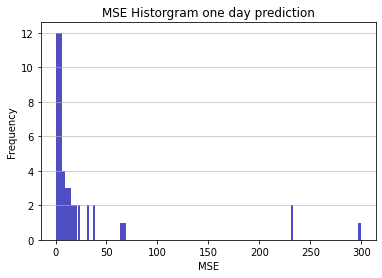

In [0]:
plt.hist(df_set50_one_day['1'], bins=100, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('MSE')
plt.ylabel('Frequency')

plt.title('MSE Historgram one day prediction')

Text(0.5, 1.0, 'MSE Historgram five days prediction')

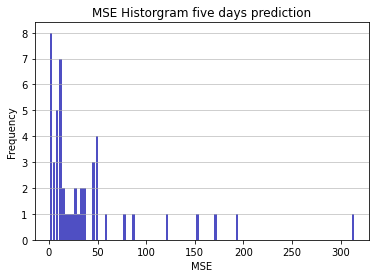

In [0]:
plt.hist(df_set50_five_days['1'], bins=100, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.title('MSE Historgram five days prediction')

Text(0.5, 1.0, 'MSE Historgram ten days prediction')

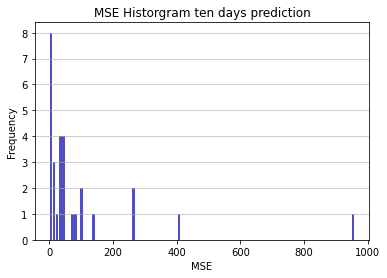

In [0]:
plt.hist(df_set50_ten_days['1'], bins=100, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.title('MSE Historgram ten days prediction')

In [0]:
print(df_set50_one_day['1'].describe())
print(df_set50_one_day[df_set50_one_day['1']<5.5][['0','1']])
print('Number of stock with lesser 5.5% MSE = '+str(len(df_set50_one_day[df_set50_one_day['1']<5.5][['0','1']])))

count     49.000000
mean      27.215419
std       61.060802
min        0.414448
25%        3.565661
50%        7.477967
75%       19.104286
max      299.453257
Name: 1, dtype: float64
            0         1
3    BANPU.BK  0.850120
5     BDMS.BK  2.227449
6      BEM.BK  1.574452
12   CPALL.BK  3.957153
13     CPF.BK  2.956984
14     CPN.BK  3.780230
15   DELTA.BK  3.995283
16    DTAC.BK  4.554961
19  GLOBAL.BK  1.846260
22   HMPRO.BK  1.925090
23  INTUCH.BK  3.565661
24    IRPC.BK  0.414448
27     KTB.BK  0.699720
29      LH.BK  0.961075
30    MINT.BK  1.744889
33     PTT.BK  3.687011
36   RATCH.BK  4.167013
40    TCAP.BK  4.505917
44     TOP.BK  5.118292
46      TU.BK  1.468572
48     WHA.BK  1.847849
Number of stock with lesser 5.5% MSE = 21


In [0]:
print(df_set50_five_days['1'].describe())
print(df_set50_five_days[df_set50_five_days['1']<5.5][['0','1']])
print('Number of stock with lesser 5.5% MSE = '+str(len(df_set50_five_days[df_set50_five_days['1']<5.5][['0','1']])))

count     50.000000
mean      39.756351
std       58.548626
min        0.700300
25%        7.595314
50%       15.572795
75%       46.978638
max      314.116485
Name: 1, dtype: float64
           0         1
3   BANPU.BK  1.612754
23  HMPRO.BK  3.320892
25   IRPC.BK  0.860036
28    KTB.BK  3.756850
30     LH.BK  2.874180
31   MINT.BK  5.370007
43    TMB.BK  0.700300
47     TU.BK  4.009992
48    VGI.BK  3.796415
49    WHA.BK  2.060792
Number of stock with lesser 5.5% MSE = 10


In [0]:
print(df_set50_ten_days['1'].describe())
print(df_set50_ten_days[df_set50_ten_days['1']<5.5][['0','1']])
print('Number of stock with lesser 5.5% MSE = '+str(len(df_set50_ten_days[df_set50_ten_days['1']<5.5][['0','1']])))

count     29.000000
mean      98.259861
std      189.829005
min        1.543295
25%       10.502754
50%       37.872614
75%       82.262616
max      957.624380
Name: 1, dtype: float64
           0         1
3   BANPU.BK  5.347815
10    BTS.BK  5.403659
24   IRPC.BK  1.543295
27    KTB.BK  4.590162
Number of stock with lesser 5.5% MSE = 4


We can see that the more longer prediction range the lower accuracy as the frequency of higher MSE increases when we compare 1 day with 5 days and 10 days prediction.

If we say that 5% MSE is the acceptable accuracy of the model for being use. We can see the number of stocks that pass this criterias for each range of prediction as below.

The result that we get is 18, 8 and 3 for 1 day, 5 days and 10 days prediction.
We can also find the list of the stocks that can be predicted with lower 5% MSE for all ranges by using set intersection as below.

In [0]:
set_fiveday = set(df_set50_five_days[df_set50_five_days['1'] < 5.5]['0'])
set_oneday = set(df_set50_one_day[df_set50_one_day['1']<5.5]['0'])
set_tenday = set(df_set50_ten_days[df_set50_ten_days['1']<5.5]['0'])

In [0]:
set_oneday.intersection(set_fiveday)

{'BANPU.BK',
 'HMPRO.BK',
 'IRPC.BK',
 'KTB.BK',
 'LH.BK',
 'MINT.BK',
 'TU.BK',
 'WHA.BK'}

In [0]:
set_oneday.intersection(set_fiveday).intersection(set_tenday)

{'BANPU.BK', 'IRPC.BK', 'KTB.BK'}

I also run 5 and 10 days prediction on SET50 for another round by adding MACD and EMA to the dataset to see how it effects the overall result.

In [0]:
df_set50_five_days = pd.read_csv('/content/drive/My Drive/Colab Notebooks/set50_5_mse.csv')
df_set50_five_days_add = pd.read_csv('/content/drive/My Drive/Colab Notebooks/set50_5_mse_add_data.csv')

Text(0.5, 1.0, 'Diff of MSE Historgram five days prediction between with and without MACD and EMA')

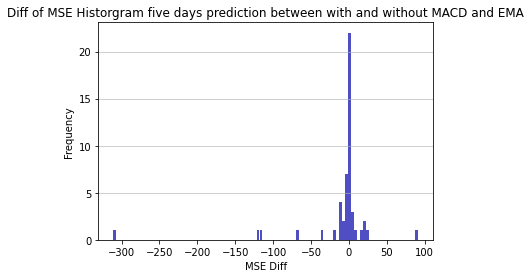

In [0]:
# compare by find the distribution of differentiate for each stock
df_set50_five_days_diff = pd.DataFrame(df_set50_five_days['1'] - df_set50_five_days_add['1'])

plt.hist(df_set50_five_days_diff['1'], bins=100, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('MSE Diff')
plt.ylabel('Frequency')
plt.title('Diff of MSE Historgram five days prediction between with and without MACD and EMA')

In [0]:
print(df_set50_five_days_diff.describe())
print('Number of stock that MSE increases after adding MACD and EMA = '+str(len(df_set50_five_days_diff[df_set50_five_days_diff['1']<0])))
print('Number of stock that MSE decreases after adding MACD and EMA = '+str(len(df_set50_five_days_diff[df_set50_five_days_diff['1']>=0])))

                1
count   50.000000
mean   -10.806557
std     52.617327
min   -311.094024
25%     -4.366777
50%     -0.253794
75%      1.181030
max     91.403275
Number of stock that MSE increases after adding MACD and EMA = 26
Number of stock that MSE decreases after adding MACD and EMA = 24


From the distribution above, we found that adding MACD and EMA does help reduce MSE for about half of SET50 stocks for 5 day prediction while it also increase MSE for another half as well.

###Summary of SET50 prediction for 1,5 and 10 days
- The parameters for 1 day prediction is able to predict 40% of stock in SET50 with lower than 5% MSE. However, the number of stock with lower than 5% MSE reduces to 10 and 4 stockes for 5 and 10 days prediction.
- The stock that has lower 5% MSE on all range of prediction is 3 stocks.
- The current parameters is created base on 1 example stock, however, it is possible to use to predict other stocks which some of them even has better accuracy than the example case.
- We can see that the MSE is increased for some stocks and also decreased  for some stocks on 10 days prediction after we add MACD and EMA as training additional features. Base on this, it is clear that to optimize stock price prediction accuracy we should scope down for one stock as the parameter won't give good result on all stocks as each stock price move due to influences of different factors.

##3. Create User-Friendly function for user to select their interested stocks, train and query for stock price prediction

After I got the set of LSTM parameters that would work best for 1, 5 and 10 days prediction, I'll try to build a script which the user can use to train the model and query for the stock price prediction.

Since LSTM model using Keras required Tensorflow and also decent machine to run, building the web server to build and train the model on web server is quite costly. 

I have tried free tier of web server on heroku but free tier web server has limited execution time of any function. Therefore, it won't be possible to run train the model which need more than 5 minutes to do.

So, I decide to create a separated notebook which provides 2 code cells. One for receiving list of stock and range of training data and another one for query the predicted price.

To do this, I need to pack all of my functions into one file so that it is easily used by upload the notebook and the functions file together to new colaboratory space and make it ready to run. I also have to modify some of my code to make it not need to mount with Google drive and able to handle some input error as listed below.

There are 2 new functions that I added to the code below which will be used as interface with the user for the script.

**- train_model** : This function will recieve stock list and range of date for downloading the stock data from Yaoo Finance. It will train the model by using the parameters that I found earlier and save the model to colaboratory file system using h5 format along with its MSE.

**- query_price** : This function will recieve the stock list that the user want to predict the price and the date range from training data's end date to predict for the stock price. The function will read the trained model and do prediction per the requested date range. Support up to 10 date range only.


In [0]:
%%file stock_predictor.py

import yfinance as yf
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
from keras.models import Sequential
from keras.utils import plot_model
from keras.models import load_model

# Yahoo Finance Library for getting historical stock data from Yahoo finance
import os.path, time
import datetime

def get_stock_data(stock_list,start_date,end_date):
    '''
        Download stock data from Yahoo Finance as listed in stock_list
        starting from start date to end date and save to CSV file.
        The default path is the same path as the running script.

        Input:
        - stock_list (String) : String of Yahoo Finance's ticker name separated by space. For example, stockA stockB stockC ...
        - start_date (String) : String of start date in format DD/MM/YYYY.
        - end_date (String) : String of end date in format DD/MM/YYYY.

        Output:
        - No return value
        - The csv file will be written with the naming convention as ticker.csv

    '''
    for stock in stock_list:
        try:
            file = stock+'.csv'
            print('Downloading data from Yahoo Finance...')
            data = yf.download(stock, start=start_date, end=end_date)
            pd.DataFrame(data).to_csv(file)
        except Exception as e:
            print("exception "+str(e)+"on "+stock)
            print("start date = "+start_date)
            print("end date = "+end_date)

def dataset_preparation(filename, history_points, predict_range, y_normaliser, mode='file', df=None):
    '''
      This function will prepare data and make it ready for training and testing the model by receiving the CSV file path or dataframe 
      equivalent to Yahoo Finance's historical data with other parameters, normalize to 0-1 range value, separate into train and test and return the result.

      Input:
      - filename (String) : The file path for csv file containing historical stock data downloaded from Yahoo Finance. 
      - history_points (Number) : The number of day range for historical data to be used for training the model.
      - predict_range (Number) : The range of day to forecast the price.
      - y_normmalizer (preprocessing.MinMaxScaler Object) :  Preprocessor for normalize the price for forecast data to be 0-1. We need this so that we could use it again for scaling up the data back to normal value.
      - df (DataFrame) : The dataframe input of the dataset. If the filename is passed and the mode is set to'file' it will be ignored.
      - mode : If it is 'file' the function will ignore df otherwise it will assume that df will be provided for preparation. This is used in the case that the data is read from CSV and append with other data features.

      Output:
      - ohlcv_histories_normalised (Array) : Array of the data features. One row consist of [day-1-open,day-1-max,day-1-min,...day-history_point ].
      - next_day_adjclose_values_normalised (Array) : Array of normalised Adj Close values transformed in the format of [day1-adj close,day2-adj close....day-predict_range adj close].
      - next_day_adjclose_values (Array) : Array of actual Adj Close values transformed in the format of [day1-adj close,day2-adj close....day-predict_range adj close].
      - y_normaliser (preprocessing.MinMaxScaler Object) : After we fit the actual value, we return it back so that it can be used again to scale the normalized result.
    '''

    # Prepare data per mode - file or dataframe input
    if mode=='file':
      # If it is file mode the function expect CSV file path to read the data
      df = pd.read_csv(filename)

    # For both mode, we will drop row with null value as we can't use it anyway
    df_na = df.dropna(axis=0)
    # Drop Date as this is time series data, Date isn't used. Also drop Close as we will predict Adj Close.
    df_na = df_na.drop(['Date','Close'],axis=1)

    # Normalise all data to the value range of 0-1 as neural network algorithm has better performance with this data range
    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(df_na)

    # Prepare the data in the format of [day-1-open,day-1-max,day-1-min,...day-history_point ] as 1 row input for predict the 'predict_range' price for train and test
    ohlcv_histories_normalised = np.array([data_normalised[i  : i + history_points].copy() for i in range(len(data_normalised) - history_points - predict_range +1)])

    # Get the actual price [day1-adj close,day2-adj close....day-predict_range adj close] for train and test
    next_day_adjclose_values_normalised = np.array([data_normalised[i + history_points:i + history_points + predict_range,3].copy() for i in range(len(data_normalised) - history_points - predict_range+1)])

    # Create the same array as the normalised adj close but with the actual value not the scaled down value. This is used to calculate the prediction accuracy
    next_day_adjclose_values = np.array([df_na.iloc[i + history_points:i + history_points+predict_range]['Adj Close'].values.copy() for i in range(len(df_na) - history_points - predict_range+1)])    

    # Use the passed normaliser to fit the actual value so that we can scale the predicted result back to actual value
    y_normaliser.fit(next_day_adjclose_values)

    return ohlcv_histories_normalised, next_day_adjclose_values_normalised, next_day_adjclose_values, y_normaliser

def get_LSTM_Model(layer_num, history_points, features_num,predict_range,optimizer,dropout_prob):

    '''
      This function will build LSTM model per provided parameters.
      The model will be a simple one consist of one forget layer with configurable forget probability and configurable number of hidden layers.

      Input:
      - layer_num (Number) : The number of hidden layer.
      - history_points (Number) : The number of data in the dataset.
      - features_num (Number) : The number of features in the dataset.
      - predict_range (Number) : The number of day to predict the stock price.
      - optimizer (Number) : The optimizer's name e.g. adam.
      - dropout_prob (Float) : Probability to forget the date on dropout layer.

      Output:
      - model (Object) : The compiled LSTM model per the provided parameters.

    '''

    # Initialize LSTM using Keras library
    model = Sequential()
    # Defining hidden layer number and the shape of the input (number of data in the dataset and the number of feature)
    model.add(LSTM(layer_num, input_shape=(history_points, features_num)))

    # Add forget (dropout) layer with probability per argument
    model.add(Dropout(dropout_prob))

    # End the network with hiddenlayer per the size of forecast day e.g. 1,5,10
    model.add(Dense(predict_range))

    # Build and return the model per the selected optimizer
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

def train_test_split(ohlcv_histories, next_day_adj_close, unscaled_y,test_split = 0.9):
    '''
        Split the dataset to train and test dataset per provideed ratio.

        Input
        - ohlcv_histories (Array) : The dataset in array.
        - next_day_adj_close (Array) : The result of prediction using the dataset in array.
        - unscaled_y (Array) : The same data as next_day_adj_close but not normalize to 0-1.
        - test_split (Float) : The ratio of train per test.

        Output
        - ohlcv_train (Array) : The train dataset splitted per test_split ratio.
        - ohlcv_test (Array) : The test dataset splitted per test_split ratio.
        - y_test (Array) : The result of test dataset splitted per test_split ratio.
        - y_train (Array) : The result of train dataset splitted per test_split ratio.
        - unscaled_y_test (Array) : The unscaled y_test per test_split ratio.
    '''
    n = int(ohlcv_histories.shape[0] * test_split)

    ohlcv_train = ohlcv_histories[:n]
    y_train = next_day_adj_close[:n]

    ohlcv_test = ohlcv_histories[n:]
    y_test = next_day_adj_close[n:]

    unscaled_y_test = unscaled_y[n:]

    return ohlcv_train, ohlcv_test, y_test, y_train, unscaled_y_test

def train_predictor(ohlcv_train,y_train,ohlcv_test,y_normaliser,unscaled_y_test,hidden_layer,batch_size,epoch,dropout_probability,history_points,features_num,predict_range):
    '''
        Create LSTM model per provideded parameter, fit the train data and validate its accuracy using MSE.
        Finally, retrun the result of MSE and the model object.

        Input
        - ohlcv_train (Array) : Train dataset in array.
        - y_train (Array) : Train dataset result in array.
        - ohlcv_test (Array) : Test dataset in array.
        - y_normaliser (preprocessing.MinMaxScaler Object) : The normaliser instance that is used to scale down y_test. We will use it to scale up the result from test dataset.
        - unscaled_y_test (Array) : The unscaled y_test using for validate the result.
        - hidden_layer (Number) : LSTM parameter's number of hidden layer.
        - batch_size (Number) : LSTM parameter's number of batch size.
        - epoch (Number) : LSTM parameter's number of epoch.
        - dropout_probability (Float) : LSTM parameter's dropout probability.
        - history_points (Number) : LSTM parameter's the number of history data to train the model in each iteration.
        - features_num (Number) : LSTM parameter's the number of features in the dataset.
        - predict_range : LSTM parameter's the number of predict data to be predicted.

        Output
        - model (Object) : LSTM model which can be saved to h5 or use to predict the result with the new dataset.
        - scaled_mse (Float) : Mean Squared Error of the model measured by using the unscaled result from test dataset minus the unscaled_y_test

    '''
    model = get_LSTM_Model(hidden_layer,history_points,features_num,predict_range,'adam',dropout_probability)
    model.fit(x=ohlcv_train, y=y_train, batch_size=batch_size, epochs=epoch, shuffle=True, validation_split=0.1,verbose=0)

    y_test_predicted = model.predict(ohlcv_test)
    y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)

    real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
    scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
    return model, scaled_mse

def train_and_validate_stock_predictor(stock,history_points,predict_range,hidden_layer,batch_size,epoch,dropout_probability, mode='file'):
    '''
        Encapsulate all activities to create LSTM model to predict the stock with parameters as provided.
        There are 2 mode for this function. mode='file' will read data from csv file and not add additional features like macd and EMA
        while other mode will read data from csv but also add macd and EMA as additional features.
        Starting from transforming data, splitting to train/test, build and fit model, evaluate the model accuracy and return result.

        Input
        - stock (String) : Ticker per Yahoo Finance.
        - history_points (Number) : LSTM parameter's the number of history data to train the model in each iteration.
        - predict_range : LSTM parameter's the number of predict data to be predicted.
        - hidden_layer (Number) : LSTM parameter's number of hidden layer.
        - batch_size (Number) : LSTM parameter's number of batch size.
        - epoch (Number) : LSTM parameter's number of epoch.
        - dropout_probability (Float) : LSTM parameter's dropout probability.

        Output
        - model (Object) : LSTM model which can be saved to h5 or use to predict the result with the new dataset.
        - scaled_mse (Float) : Mean Squared Error of the model measured by using the unscaled result from test dataset minus the unscaled_y_test
    '''
    # Read data and add MACD and EMA
    if mode=='file':
        features_num = 5
        ohlcv_histories, next_day_adj_close, unscaled_y, y_normaliser = dataset_preparation(stock+'.csv',history_points,predict_range,preprocessing.MinMaxScaler())
    else:
        df = add_macd_ema(pd.read_csv(stock+'.csv'))
        ohlcv_histories, next_day_adj_close, unscaled_y, y_normaliser = dataset_preparation('',history_points,predict_range,preprocessing.MinMaxScaler(),mode='df',df=df)
        features_num = len(df.columns)-2

    ohlcv_train, ohlcv_test, y_test, y_train, unscaled_y_test = train_test_split(ohlcv_histories,next_day_adj_close,unscaled_y)

    model, scaled_mse = train_predictor(ohlcv_train,y_train,ohlcv_test,y_normaliser,unscaled_y_test,hidden_layer,batch_size,epoch,dropout_probability,history_points,features_num,predict_range)
    return model, scaled_mse

def add_macd_ema(df,ema1=20,ema2=50):
    '''
        Compute stock technical analysis indicator - MACD and EMA and add back to the dataset

        Input
        - df (DataFrame) : The DataFrame of stock data as downloaded from Yahoo Finance
        - ema1 (Number) : The first EMA period to add to the dataset
        - ema2 (Number) : The second EMA period to add to the dataset

        Output
        - df (DataFrame) : The DataFrame with new columns added - MACD, ema1 and ema2 e.g. MACD, 20, 50 are the default column name that will be added
    '''
    df_close = df[['Close']]
    df_close.reset_index(level=0, inplace=True)
    df_close.columns=['ds','y']

    exp1 = df_close.y.ewm(span=12, adjust=False).mean()
    exp2 = df_close.y.ewm(span=26, adjust=False).mean()
    macd = exp1-exp2

    df = pd.merge(df,macd,how='left',left_on=None, right_on=None, left_index=True, right_index=True)
    df.columns = ['Date','Open','High','Low','Close','Adj Close','Volume','MACD']
    df[ema1] = df['Close'].ewm(span=ema1, adjust=False).mean()
    df[ema2] = df['Close'].ewm(span=ema2, adjust=False).mean()

    return df

def display_test_validation_graph(unscaled_y_test, y_test_predicted):
    '''
        Display the plot of the stock price in test dataset and the predicted data.

        Input
        - unscaled_y_test (Array) : The array of stock price in test dataset.
        - y_test_predicted (Array) : The array of stock price as predicted.

        Output
        - No return value.
        - The plot will be displayed on the screen.
    '''
    plt.gcf().set_size_inches(22, 15, forward=True)

    start = 0
    end = -1

    real = plt.plot(unscaled_y_test[start:end], label='real')
    pred = plt.plot(y_test_predicted[start:end], label='predicted')

    plt.legend(['Real', 'Predicted'])

    plt.show()

def train_model(stock_list, start_date, end_date):
    '''
        Initial function for the user to use by provide stock list, start and end date of data to train the prediction model.
        The function will call other function to download data from Yahoo finance per specific start and end date.
        Then, prepare the data and build LSTM model for stock price prediction of 1,5 and 10 day using the set of parameters
        that has been tuned that it can get some good result for SET50 and written all 3 models (per stock) to h5 file along with list of MSE of each model on the same path of the script.

        Input
        - stock_list (String) : List of ticker in space delimited format e.g. tickerA tickerB tickerC.
        - start_date (String) : The string of start date in format DD/MM/YYYY.
        - end_date (String) : The string of end date in format DD/MM/YYYY.

        Output
        - No return value.
        - Print the model training progress on the screen.
    '''
    
    # Split the stock_list to array
    stock_list = stock_list.split(' ')
    
    # Convert string to datetime object
    start_date = datetime.datetime.strptime(start_date,"%d/%m/%Y")
    end_date = datetime.datetime.strptime(end_date,"%d/%m/%Y")

    try:
        get_stock_data(stock_list, start_date, end_date)
    except Exception as e:
        print("exception "+str(e)+"on "+stock_list)
    
    # Array for recording MSE from each round of training
    mse_list = [] 
    
    # Train model to predict 1, 5 and 10 days using the best parameters from SET50 as found
    # Save the trained model to h5 format to be used by query price function
    for stock in stock_list:

        print('start model training for stock = '+stock+'. It may take at least 5 minutes...')

        # Train model for 1 day predict range by using parameters that we found from our study earlier

        # Set up parameters for the model
        predict_range = 1
        history_points = 90
        hidden_layer = 10
        batch_size = 10
        epoch = 90
        dropout_probability = 1.0
        mode = 'file'

        try:
            model, scaled_mse = train_and_validate_stock_predictor(stock,history_points,predict_range,hidden_layer,batch_size,epoch,dropout_probability,mode)
            mse_list.append([stock, predict_range, scaled_mse])
            model.save(stock+'_'+str(predict_range)+'.h5')
        except Exception as e:
            print("exception "+str(e)+"on "+stock)
            pd.DataFrame(columns=['predict rage','stock','exception'],data=[predict_range,stock,str(e)]).to_csv('exception.csv')
            continue

        # Train model for 5 days predict range by using parameters that we found from our study earlier

        # Set up parameters for the model
        predict_range = 5
        history_points = 30
        hidden_layer = 70
        batch_size = 10
        epoch = 60
        dropout_probability = 1.0
        mode = 'file'

        try:
            model, scaled_mse = train_and_validate_stock_predictor(stock,history_points,predict_range,hidden_layer,batch_size,epoch,dropout_probability,mode)
            mse_list.append([stock, predict_range, scaled_mse])
            model.save(stock+'_'+str(predict_range)+'.h5')
        except Exception as e:
            print("exception "+str(e)+"on "+stock)
            pd.DataFrame(columns=['predict rage','stock','exception'],data=[predict_range,stock,str(e)]).to_csv('exception.csv')
            continue

        # Train model for 10 days predict range by using parameters that we found from our study earlier
        predict_range = 10
        history_points = 50
        hidden_layer = 60
        batch_size = 10
        epoch = 80
        dropout_probability = 0.3
        mode = 'file'

        try:
            model, scaled_mse = train_and_validate_stock_predictor(stock,history_points,predict_range,hidden_layer,batch_size,epoch,dropout_probability,mode)
            print("Predict {} days for {} with MSE = {}".format(str(predict_range),str(stock),str(scaled_mse)))
            mse_list.append([stock, predict_range, scaled_mse])
            model.save(stock+'_'+str(predict_range)+'.h5')
        except Exception as e:
            print("exception "+str(e)+"on "+stock)
            pd.DataFrame(columns=['predict rage','stock','exception'],data=[predict_range,stock,str(e)]).to_csv('exception.csv')
            continue

    print("Completed...")
    pd.DataFrame(mse_list).to_csv('mse_list.csv')

def query_price(stock_list,date_range):
    '''
        Query the predicted price from the model of the stocks that were trained by providing the stock name and the date range of prediction from the end date of training data.
        It supports only 1,5 and 10 date range.

        Input
        - stock_list (String) : List of ticker in space delimited format e.g. tickerA tickerB tickerC.
        - date_range (Number) : The number of date range to predict the price - 1, 5 and 10 days from end date of the training data set.
    '''
    
    # Split the stock list to array
    stock_list = stock_list.split(' ')
    
    # Read MSE of the trained model for each stock and each range of prediction
    df_mse = pd.read_csv('mse_list.csv')
    
    if date_range <=10:
        for stock in stock_list:
            
            try:
                
                # Do prediction by using history_points of data as we found from our study earlier
                if date_range == 1:
                    predict_range = 1
                    history_points = 90
                    mode = 'file'
                if date_range <= 5:
                    predict_range = 5
                    history_points = 30
                    mode = 'file'
                if date_range <= 10:
                    predict_range = 50
                    history_points = 90
                    mode = 'df'
                
                model = load_model(stock+'_'+str(predict_range)+'.h5')
                
                df_stock = pd.read_csv(stock+'.csv')
                df_stock = add_macd_ema(df_stock)

                ohlcv_histories, next_day_adj_close, unscaled_y, y_normaliser = dataset_preparation(stock+'.csv',history_points,predict_range,preprocessing.MinMaxScaler(),mode=mode,df=df_stock)

                adj_predicted = model.predict(ohlcv_histories[len(ohlcv_histories)-1:])
                adj_predicted = y_normaliser.inverse_transform(adj_predicted)

                print(stock+' price prediction for '+str(date_range)+' days : '+str(adj_predicted[0][:date_range]))
                print("Mean square error = "+str(df_mse[(df_mse['0']==stock) & (df_mse['1']==predict_range)]['2'].values)+" %")
            except Exception as e:
                print("There was an error : "+str(e))
                continue
                
    else:
        print("Support prediction from the end date of training data for 1 to 10 days only. Please try again.")
        
    


Writing stock_predictor.py


To distributed these as reusable script, I'll create a new Jupyter Notebook which has the following cells with predefine code.

In [0]:
# stock_list                : List of stock. Make sure that it is searchable on Yahoo finance. Put them inside ' ' and separate by one space
# training_data_start_date  : Start date for the range of history data that you want to use it to train the model. Minimum range is 90 days. The format date is DD/MM/YYYY.
# training_data_end_date    : The end date for the range of history data that you want to use it to train the model. The day after end date is the first date for stock price prediction.

stock_list = 'ASK.BK INTUCH.BK'   
training_data_start_date = '08/05/2000'
training_data_end_date = '13/05/2020' 

# ------ DO NOT CHANGE CODE BELOW THIS LINE --------

!pip install yfinance
import yfinance as yf
import os,sys
sys.path.append(os.path.abspath("/content/stock_predictor.py"))
from stock_predictor import *
train_model(stock_list,training_data_start_date,training_data_end_date)

`sys.path.append` will import the functions in stock_predictor.py so we could use this way to pack all of the functions and the required dependencies in one file.

Another cell for query the result with code as below.

In [0]:
# query_list      : List of stock to query for the predict price. It must be subset of stock_list. Each stock ticker separates by one space.
# prediction_rage : Day range from the training_data_end_date to predict for the stock price. Support at 10 as maximum date rage

query_list = 'ASK.BK INTUCH.BK'
prediction_range = 5

query_price(query_list,prediction_range)

The result will be printed on the output panel.

I will add both cells in a more user-friendly notebook - stock_predictor which is in the same repository as this notebook - https://github.com/pathompong-y/stock_predictor

#Conclusion

1. One way to tune the parameter of LSTM is to iteratively adjust one by one by starting from setting every parameter at lowest and iteratively change only one parameter at a time to find the value that has lowest MSE. Then, use that parameter value along with other parameters and iterate to find the best value of the next parameter.

2. The result of parameters that we get base on using the data of open, high, low, volume to predict adj. close can be used to predict other stocks as well. If we use 5.5% MSE as acceptable error rate we can use this parameters to predict 40% of stock in SET50 for 1 day prediction, 20% of stock for 5 days prediction and about 5% of stock for 10 days prediction.

3. The longer range of prediction the higher error that we will get.

4. Adding technical analysis indicator like MACD and EMA does help improve the prediction accuracy for 50% of the stock in 5 days prediction.

6. At the end of the day, to optimize accuracy of the prediction we have to do it stock by stock as the fetures that will effect is varies.

#Further improvement

1. We have lot of possiblities to improve the model further which can try for example we can adjust the EMA range or even add other technical analysis indicators and play around combination of them.

2. We may also re-group the stock that the prices movements are based on the same set of certain criterias. For example grouping companies in Oil & Gas together and we may add oil price as additional data features as these companies stock price will effected by the oil price movement.

